# **Semantic Segmentation Using HAGDAVS Dataset**

### **Import Libraries**

In [1]:
%%capture
!pip uninstall tensorflow -y
!pip uninstall tensorflow-io -y
!pip install tensorflow
!pip install --no-deps tensorflow-io

In [2]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import pathlib
from PIL import Image
import shutil
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.data import AUTOTUNE

## **Load Data**

This code performs the following actions:

1. Defines directory paths for the input data, including the folder containing RGB images and the folder containing masks.
2. Sets the destination folder path to save the modified images.
3. Creates the new destination folder if it doesn't exist.
4. Retrieves the list of file names in the masks folder.
5. Iterates over each file in the list and does the following:
   - Checks if the file name contains the text "MClass".
   - If it does, modifies the file name by replacing "MClass" with "RGB".
   - Creates an old file path and a new file path.
   - Copies the old file to the new path.

In summary, the code takes masks in the "MClass" format and copies them to a new folder, but changes their names to the "RGB" format.

In [3]:
#Cambiar los paths
data_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS') #Create a path 
images_dir = data_dir / 'RGB' #Append RGB and MASK to the data_dir
masks_dir = data_dir / 'MASK'

folder_path = masks_dir  # Ruta de la carpeta que contiene las imágenes
new_folder_path = '/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/MASK'#Is a existing directory

# Crear la nueva carpeta si no existe
os.makedirs(new_folder_path, exist_ok=True)

# Obtener la lista de nombres de archivo en la carpeta
file_list = os.listdir(folder_path)

# Aplicar la modificación del nombre y crear nuevos archivos en la nueva carpeta
for filename in file_list:
    if "MClass" in filename:
        new_filename = filename.replace("MClass", "RGB")
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(new_folder_path, new_filename)
        shutil.copy2(old_path, new_path) #Coping the files from the old path to the new path with shutil

This code performs the following actions:

1. Defines directory paths for the image and mask folders.
2. Retrieves a list of file paths for the images and masks.
3. Creates empty lists to store image and mask patches.
4. Sets the desired patch size.
5. Defines a function to load and split the images and masks into patches.
   - It reads the image and mask files.
   - Removes the alpha channel from the images and masks.
   - Divides the image into patches based on the specified patch size.
   - Checks if all pixels in a mask patch are black, and if so, skips it.
   - Appends the image and mask patches to their respective lists.
6. Applies the load_and_split_patches function to each image and mask pair.
7. Converts the lists of patches into TensorFlow tensors.
8. Creates a dataset from the image and mask patches.

In summary, the code loads image and mask files, divides them into patches of a specified size, filters out patches with all-black masks, and creates a dataset for further processing or training.

In [4]:
import tensorflow as tf
import tensorflow_io as tfio
import pathlib

# Ruta a las carpetas de imágenes y máscaras
ima_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = ima_dir / 'RGB'
m_dir = pathlib.Path('/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS')
mask_dir = m_dir / 'MASK'

# Obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.tif')]) #Retrieve all the routes end up with .tif
mask_paths = sorted([str(path) for path in mask_dir.glob('*.tif')])

# Crear una lista para almacenar los parches de imágenes y máscaras
image_patches = []
mask_patches = []

# Tamaño del parche deseado
patch_size = (128, 128) #Images a little bit large, they split in 256x256


# Definir una función para cargar y dividir las imágenes y máscaras en parches
def load_and_split_patches(image_path, mask_path):
    image = tfio.experimental.image.decode_tiff(tf.io.read_file(image_path)) #Read and decode the images into tensores
    mask = tfio.experimental.image.decode_tiff(tf.io.read_file(mask_path))

    # Eliminar el canal alfa de las imágenes y máscaras
    image = image[:, :, :3] #Only gets the fisrt three channels of the images
    mask = mask[:, :, :3]

    # Dividir la imagen en parches
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch_image = image[i:i+patch_size[0], j:j+patch_size[1], :]
            patch_mask = mask[i:i+patch_size[0], j:j+patch_size[1], :]

            # Verificar si todos los píxeles en el parche de la máscara son negros
            if tf.reduce_all(tf.math.equal(patch_mask, [0, 0, 0])): #No sirven parches solo con una clase
                continue #Meaning take next
                
            #patch_mask = convertir_colores(patch_mask)
            image_patches.append(patch_image)
            mask_patches.append(patch_mask)

    return None

# Aplicar la función de carga y división de parches a cada par de rutas de archivo
for image_path, mask_path in zip(image_paths, mask_paths):
    load_and_split_patches(image_path, mask_path)

# Convertir las listas de parches en tensores
image_patches = tf.convert_to_tensor(image_patches)
mask_patches = tf.convert_to_tensor(mask_patches)

# Crear un dataset a partir de los parches de imágenes y máscaras
dataset = tf.data.Dataset.from_tensor_slices((image_patches, mask_patches))

The size of images in dataset:

In [5]:
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None))>

## **Display Data**

Function for show the image, mask and prediction mask

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i])) #Convert to a PIL image object
    plt.axis("off")
  plt.show()

## **Using only one class**

This code defines a function called `convertir_mascara` and applies it to a dataset using the `map` function.

The `convertir_mascara` function performs the following actions:

1. Casts the input mask tensor to `float32` data type.
2. Creates a new mask tensor filled with zeros, with dimensions `(256, 256, 1)`.
3. Assigns values corresponding to each class in the mask:
   - If all RGB values in the mask are `[0, 0, 0]`, assigns `0.0` to the corresponding pixel in the converted mask.
   - If all RGB values are `[255, 0, 0]`, assigns `0.0`.
   - If all RGB values are `[0, 255, 0]`, assigns `1.0`.
   - If all RGB values are `[0, 0, 255]`, assigns `0.0`.
4. Returns the converted mask.

The code then applies the `convertir_mascara` function to each element in the `dataset` using the `map` function. The `map` function takes a lambda function that applies the conversion function to each `(image, mask)` pair in the dataset, resulting in a new dataset named `mapped_dataset`. The images in the dataset remain unchanged, while the masks are converted using the `convertir_mascara` function.

In [7]:
def convertir_mascara(mascara): #Entrenar solamente clase fondo y vehículos
    mascara = tf.cast(mascara, dtype=tf.float32) #Convert the tensor type
    mascara_convertida = tf.zeros((128, 128, 1), dtype=tf.float32) #Create a tensor of zeros

    # Asigna valores correspondientes a cada clase
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida) #tf.equal to compare 'mascara' tensor with specific RGB color value for each class
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [255, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida) #tf.reduce_all function checks if all elements along the last dimension of the resulting boolean tensor are true
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 255, 0]), axis=-1, keepdims=True), 1.0, mascara_convertida) #if so, it assigns a specific value 0.0 or 1.0 to the corresponfing position in the 'mascara convertida' tensor usign tf.where
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 255]), axis=-1, keepdims=True), 0.0, mascara_convertida)

    return mascara_convertida

mapped_dataset = dataset.map(lambda x, y: (x, convertir_mascara(y)))

This code defines a function called `filter_func` that filters the `mapped_dataset` based on certain criteria using the `filter` function.

The `filter_func` function performs the following actions:

1. Reshapes the mask tensor into a 1-dimensional tensor.
2. Uses `tf.unique` to obtain the unique classes present in the mask.
3. Checks if the number of unique classes (`tf.size(unique_classes)`) is greater than or equal to 2.
   - If there are two or more unique classes, it returns `True`, indicating that the image and mask pair should be included in the filtered dataset.
   - If there are fewer than two unique classes, it returns `False`, indicating that the image and mask pair should be filtered out.

The code then applies the `filter_func` function to each element in the `mapped_dataset` using the `filter` function. The `filter` function takes the lambda function `filter_func` as an argument and returns a new dataset named `filtered_dataset` that contains only the image and mask pairs that satisfy the filtering criteria.

In [8]:
import tensorflow as tf

def filter_func(image, mask): #Filtrar para donde solo hay una clase
    unique_classes = tf.unique(tf.reshape(mask, [-1]))[0] #Reshape tensor into 1-D tensor and retrieve of unique values [0]
    return tf.size(unique_classes) >= 2

filtered_dataset = mapped_dataset.filter(filter_func) #Retrieve elements with true

dataset_length = 0
for _ in filtered_dataset:
    dataset_length += 1

print("Longitud aproximada del dataset filtrado:", dataset_length)

Longitud aproximada del dataset filtrado: 1959


## **Splitting data**

train/test/val split

In [9]:
# dividir el dataset en conjuntos de entrenamiento, validación y prueba
#Jugar con tamaños de validación y entrenamiento y batch size

total_samples = (dataset_length)
train_size = int(0.7 * total_samples) #70% for training
val_size = int(0.15 * total_samples) #15% for validation
test_size = total_samples - train_size - val_size #Remaining size for testing

train_dataset = filtered_dataset.take(train_size) #Taking the first 'train_size' number of samples from the filtered dataset
val_dataset = filtered_dataset.skip(train_size).take(val_size) #Skip the first 'train_size' and then take the next 'val_size'
test_dataset = filtered_dataset.skip(train_size + val_size).take(test_size)

In [10]:
#Define batch_size and buffer_size
BATCH_SIZE = 4
BUFFER_SIZE = 100 #The number os samples that will be shuffled randomly in training

In [11]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #cache() save elements into memory
#shuffle() shuffle the elements onf the dataser randomly, buffer_size is the number of elements in the buffer used for shuffling
#batch() group elements into batches of batch_size
#repeat() repeat sataset indefinetely, allowing the model to iterate over the data multiple times during training
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #Prefetching overlaps the data preprocessing and model execution
#improving training performance by fetching the next batch of data while the model is training on the current batch
#AUTOTUNE allows tf to automatically determine the optimal prefetch buffer size based on available system resources
validation_batches = test_dataset.batch(BATCH_SIZE) #Create batch in validation and test
test_batches = test_dataset.batch(BATCH_SIZE)

## **VGG16**

In [12]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
#conv_base.summary()

## **Unet**

In [14]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
#Jugar con capas, filtros, dropout y normalización

def double_conv_block(x, n_filters): #Define function of convolution 2D block

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x) #, activity_regularizer=tf.keras.regularizers.l1(1e-5)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dropout
    x = layers.Dropout(0.1)(x)

    return x

def downsample_block(x, n_filters): #Make maxpooling and dropout
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)

    return f, p

def upsample_block(x, conv_features, n_filters): #Upsampling and concatenation
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x) #Stride 2
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.1)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

#Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.5),
        layers.RandomContrast(0.5),
        layers.RandomBrightness(0.5),
        layers.RandomTranslation(height_factor=0.3, width_factor=0.3)
    ]
)
    
def build_unet_model(): #Build all the U-Net model

    # inputs
    inputs = layers.Input(shape=(128,128,3))
 
    #Data augmentation
    inputs = data_augmentation(inputs)
    
    #VGG16 model
    #inputs = keras.applications.vgg16.preprocess_input(inputs)
    #inputs = conv_base(inputs)
    
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64) #It take into account the first convolutional block
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
  
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    bottleneck = layers.Dropout(0.2)(bottleneck)
    
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    
    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9) #Clasificación binaria

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

# Función de pérdida
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def mIoU(y_pred, y_true):
    I = K.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = K.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return K.reduce_mean(I / U)

#loss = keras.losses.sparse_categorical_crossentropy()

#Funcion de pérdida customizada, optimizador customizado

adam = keras.optimizers.Adam(learning_rate=0.0001)
unet_model.compile(optimizer=adam,
                   loss=dice_coef_loss,
                   metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]) #['accuracy']

In [15]:
keras.backend.clear_session()
NUM_EPOCHS = 50
BATCH_SIZE = 4

STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 20
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

import time

ini = time.time()
model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,)
fin = time.time()

Epoch 1/50


2023-06-28 23:16:28.794654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


489/489 [==============================] - 122s 179ms/step - loss: 0.4881 - dice_coef: 0.5119 - mean_io_u: 0.5537 - val_loss: 0.4808 - val_dice_coef: 0.5192 - val_mean_io_u: 0.4774
Epoch 2/50
489/489 [==============================] - 82s 168ms/step - loss: 0.3337 - dice_coef: 0.6663 - mean_io_u: 0.5693 - val_loss: 0.3476 - val_dice_coef: 0.6524 - val_mean_io_u: 0.5002
Epoch 3/50
489/489 [==============================] - 84s 171ms/step - loss: 0.3062 - dice_coef: 0.6939 - mean_io_u: 0.5808 - val_loss: 0.6125 - val_dice_coef: 0.3875 - val_mean_io_u: 0.4417
Epoch 4/50
489/489 [==============================] - 84s 172ms/step - loss: 0.2736 - dice_coef: 0.7261 - mean_io_u: 0.5992 - val_loss: 0.3482 - val_dice_coef: 0.6518 - val_mean_io_u: 0.4518
Epoch 5/50
489/489 [==============================] - 84s 172ms/step - loss: 0.2516 - dice_coef: 0.7481 - mean_io_u: 0.5921 - val_loss: 0.3522 - val_dice_coef: 0.6478 - val_mean_io_u: 0.7292
Epoch 6/50
489/489 [==============================] - 8

In [16]:
#unet_model.summary()

In [17]:
#tf.keras.utils.plot_model(unet_model)

## **Training**

In [18]:
print(f'el tiempo de ejecución son: {(fin-ini)/60} minutos')

el tiempo de ejecución son: 70.51634951829911 minutos


## **Visualization of the loss and accuracy**

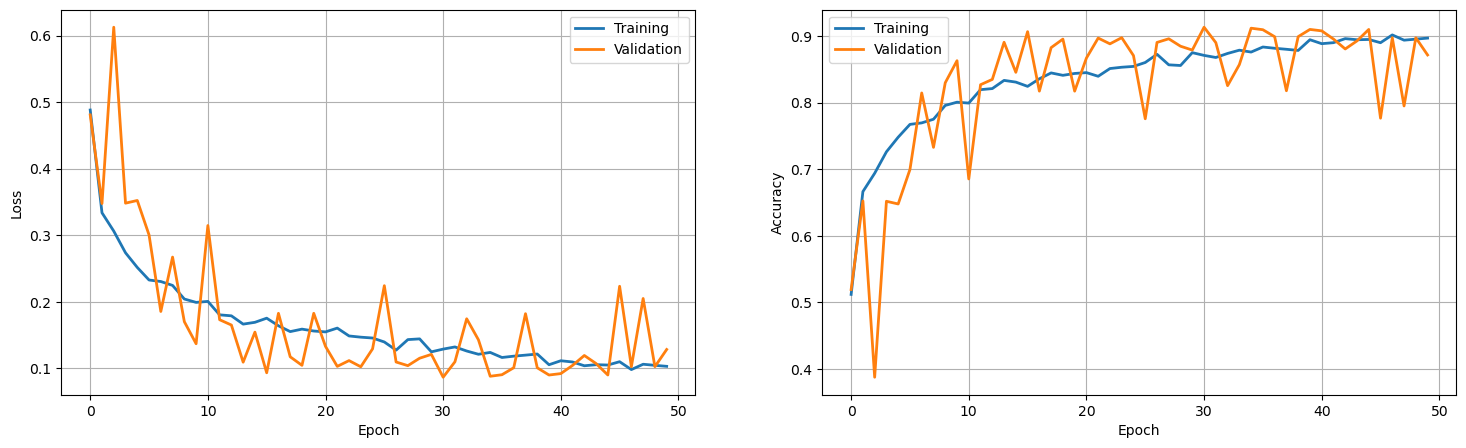

In [19]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training', linewidth=2) #model_history.history['loss']
plt.plot(model_history.history['val_loss'], label='Validation', linewidth=2) #model_history.history['val_loss']
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_history.history['dice_coef'], label='Training', linewidth=2) #model_history.history['accuracy']
plt.plot(model_history.history['val_dice_coef'], label='Validation', linewidth=2) #model_history.history['val_accuracy']
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## **Visualization of predictions**

In [20]:
i = 1 #Number of image

def create_mask(pred_mask, threshold=0.2):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[i]

def show_predictions(dataset, model, num):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[i], mask[i], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 601ms/step


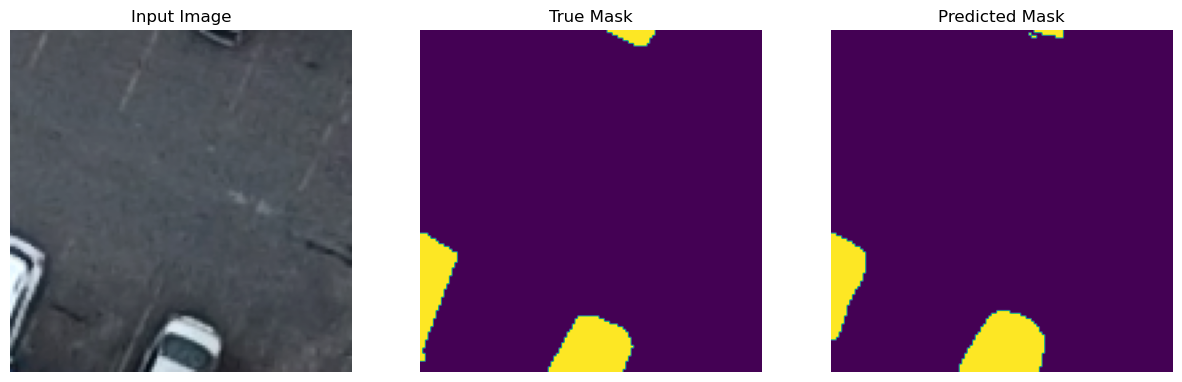

1/1 [==============================] - 0s 24ms/step


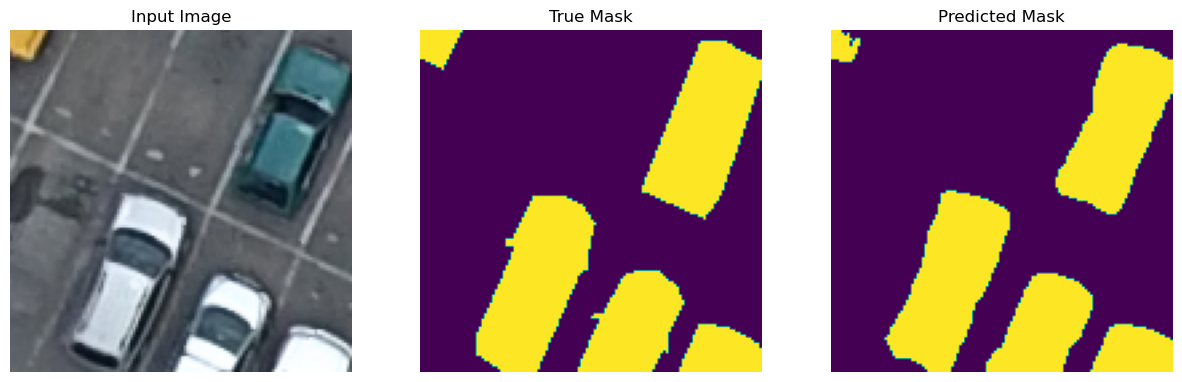

1/1 [==============================] - 0s 24ms/step


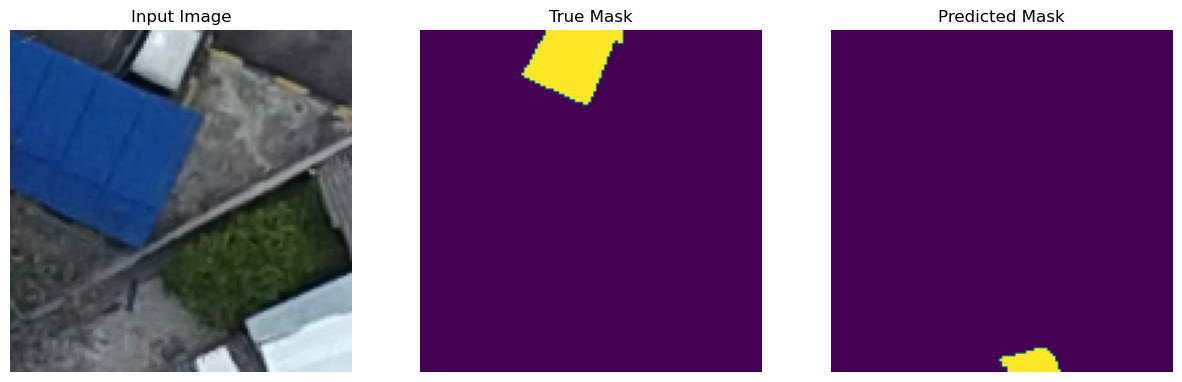

1/1 [==============================] - 0s 21ms/step


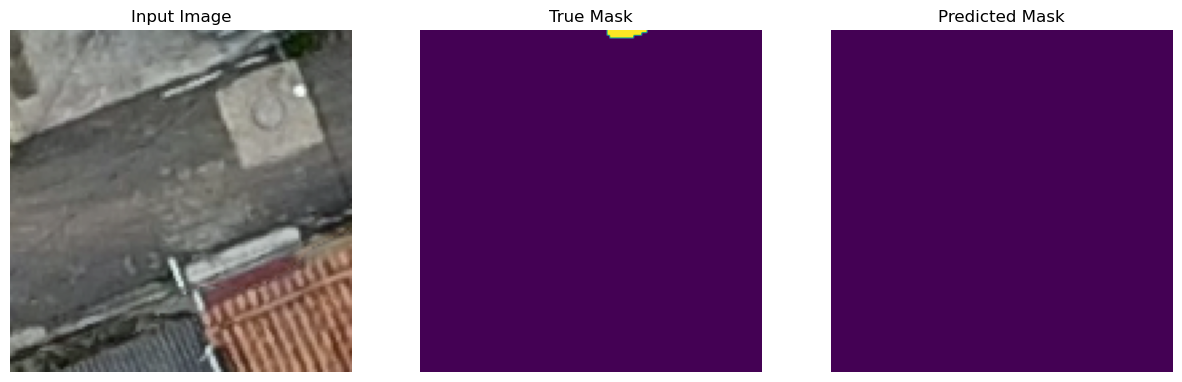

1/1 [==============================] - 0s 23ms/step


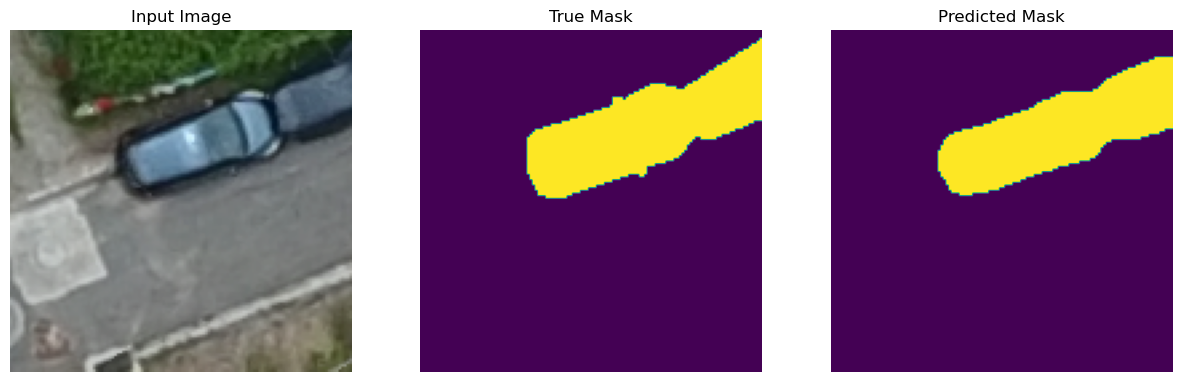

1/1 [==============================] - 0s 22ms/step


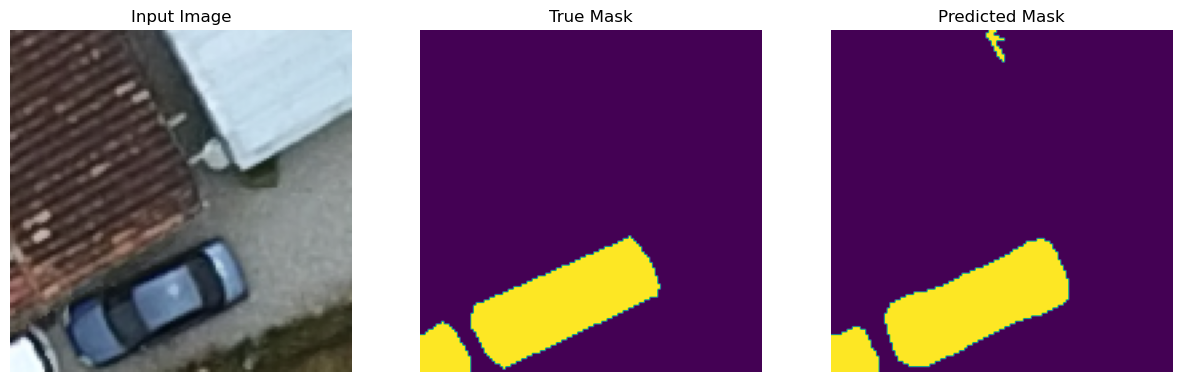

1/1 [==============================] - 0s 22ms/step


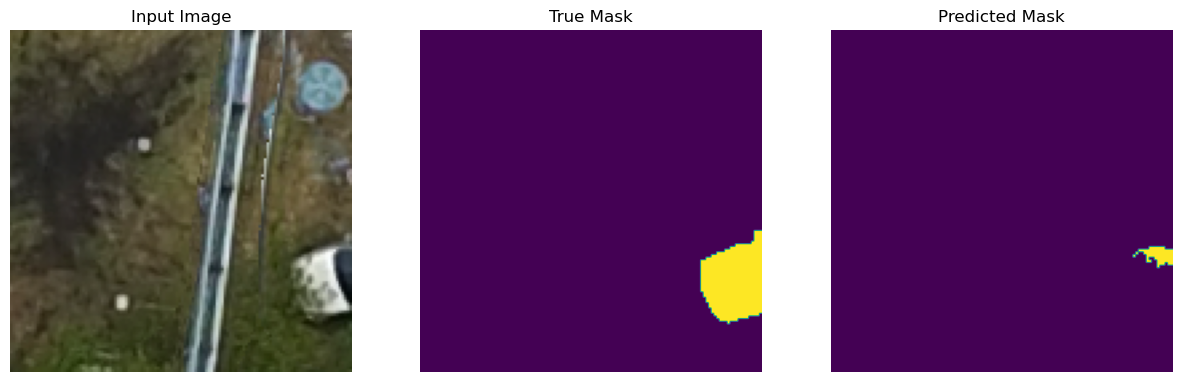

1/1 [==============================] - 0s 22ms/step


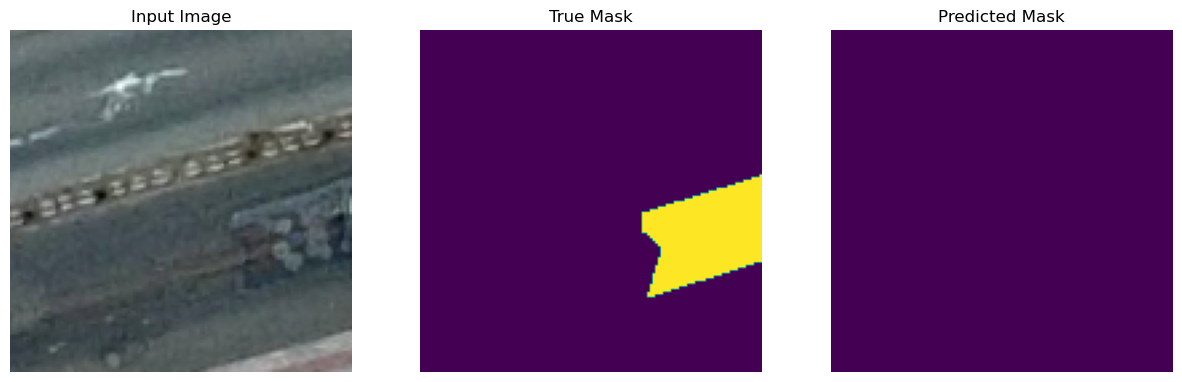

1/1 [==============================] - 0s 22ms/step


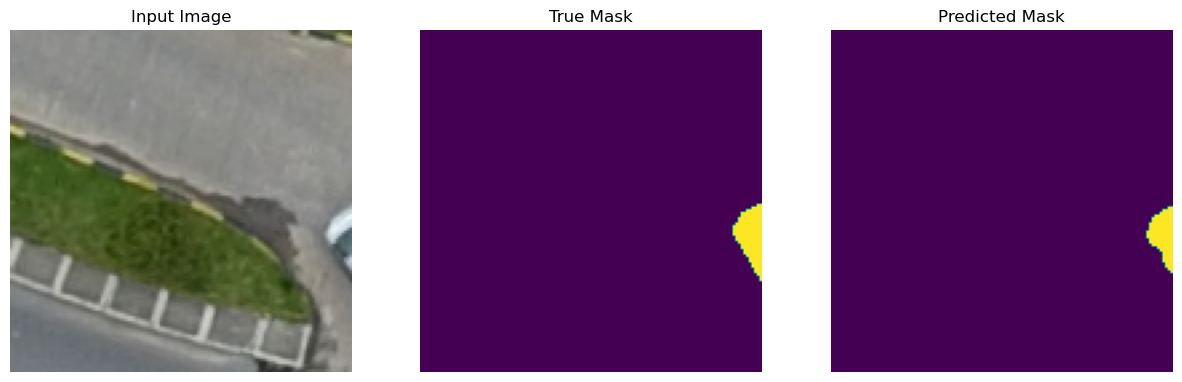

1/1 [==============================] - 0s 23ms/step


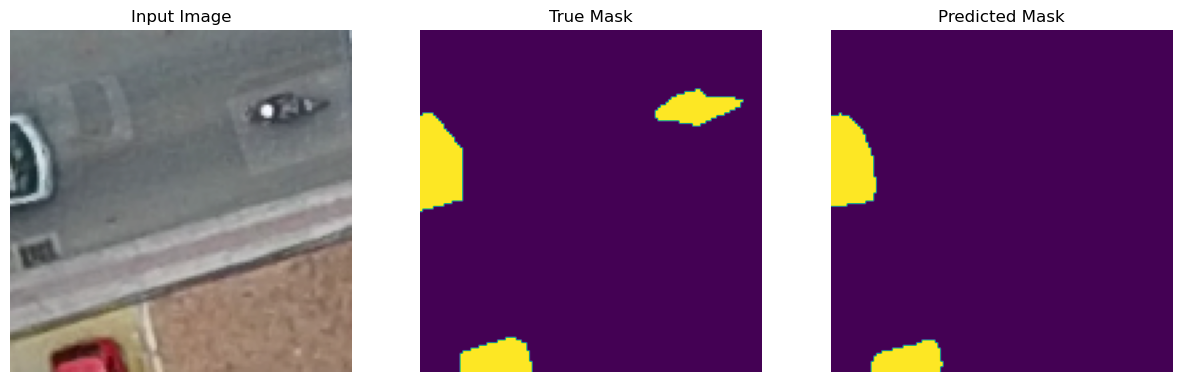

1/1 [==============================] - 0s 23ms/step


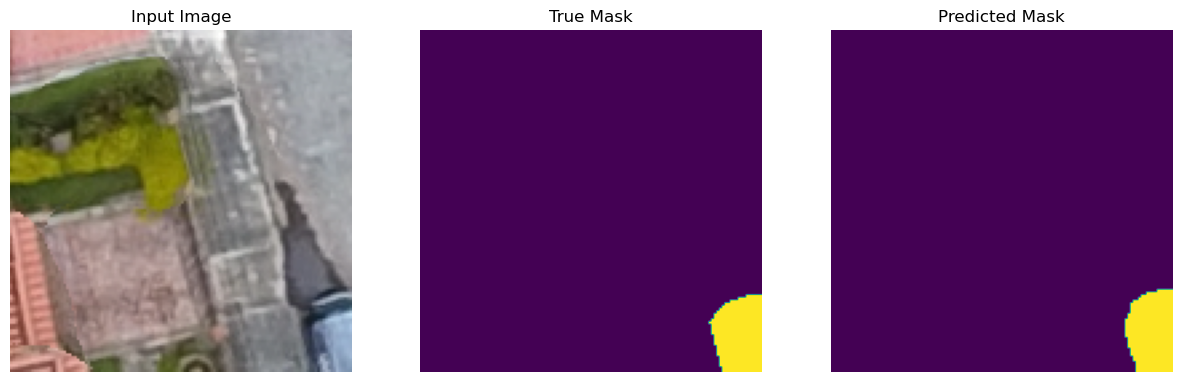

1/1 [==============================] - 0s 21ms/step


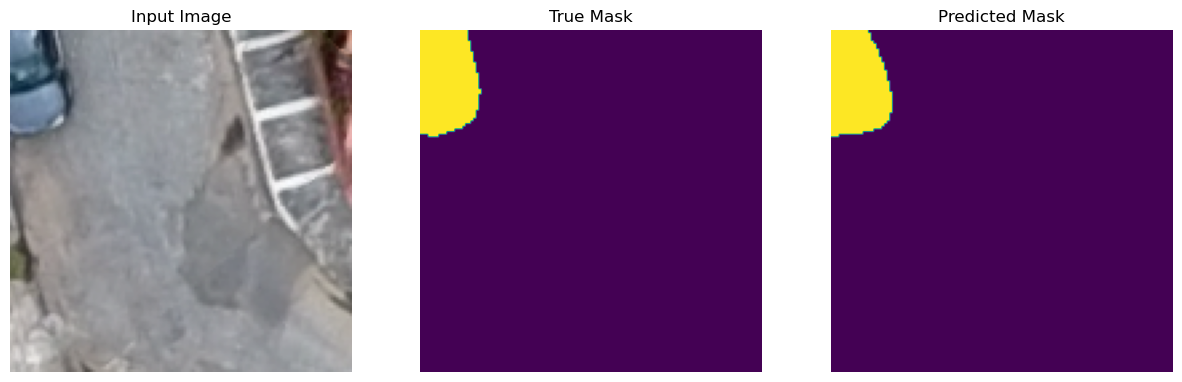

1/1 [==============================] - 0s 22ms/step


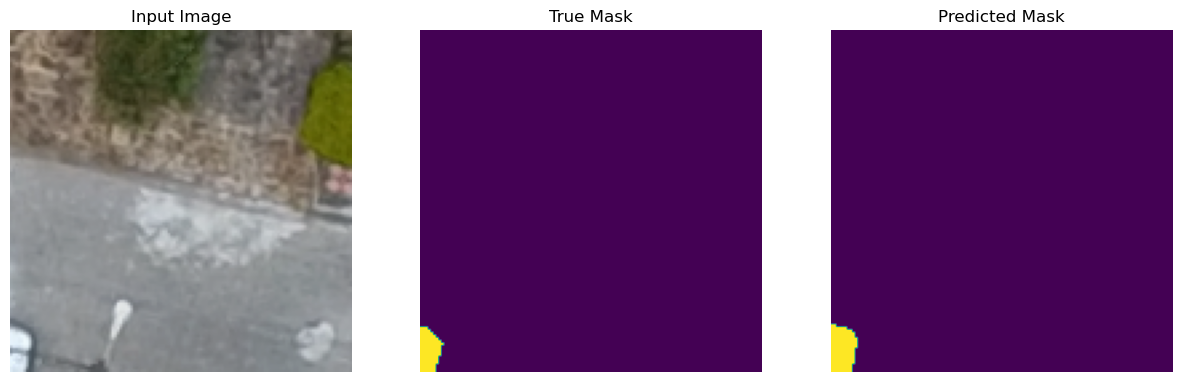

1/1 [==============================] - 0s 22ms/step


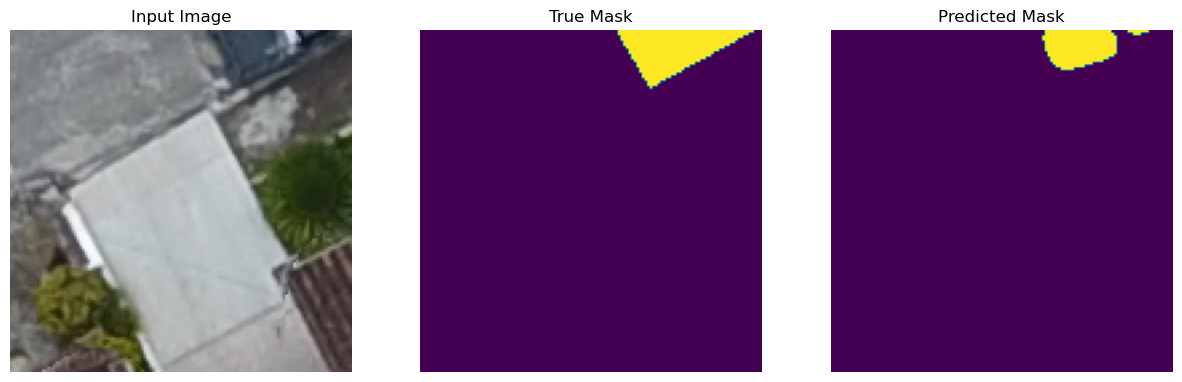

1/1 [==============================] - 0s 24ms/step


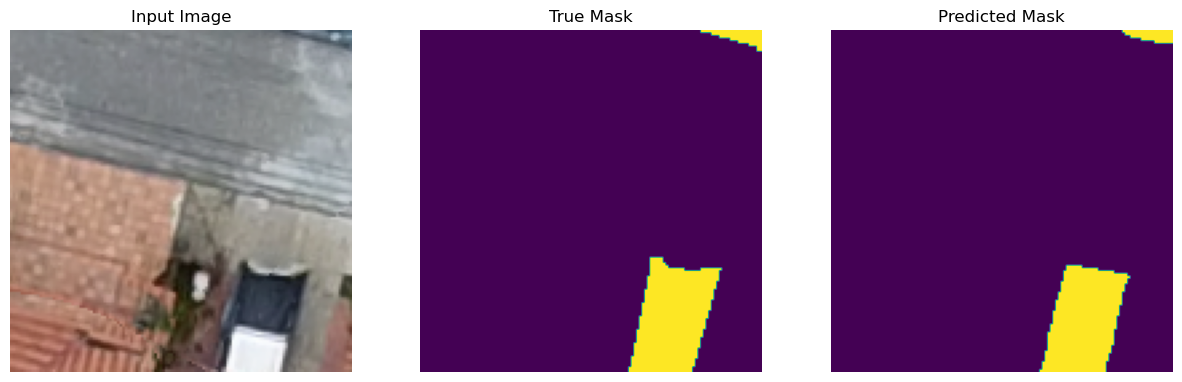

1/1 [==============================] - 0s 22ms/step


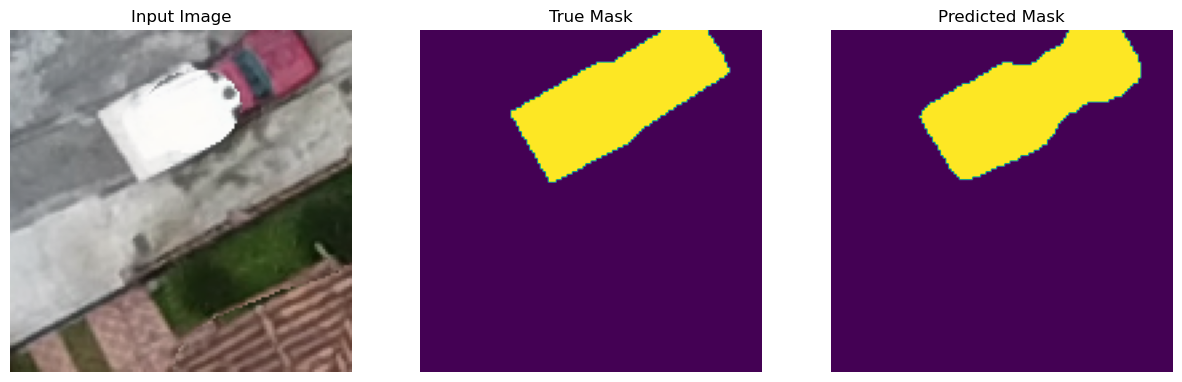

In [21]:
show_predictions(test_batches, unet_model, 16)

# Entregar en un repo de github.
# Documentar lo que se ha entregado.
# Podemos usar pesos preentrenados de una red.
# Jugar funciones de pérdida, optimizadores, dropout, aumentar la data porque son pocos datos (800) imágenes.
# Hasta el jueves 6 pm hora colombiana.
# Hacerlo con todas las clases.